In [1]:
# default_exp analyses

# The Lag-Contiguity Effect in Repetition Data
The lag-contiguity effect illustrates how episodic associations are graded, exhibiting power-function decay with increasing lag. 
Recall of an item has a tendency to evoke not only adjacent list items, but other nearby items as well. 
In addition, episodic associations appear to be a|symmetrical, favoring retrieval of items in the forward order.

Here we extend on previous implementations to ensure recall rates are successfully measured and visualized when study lists can include two presentations of study items. 

To measure the lag-contiguity effect, we often produce lag-CRP curves. 
"Lag-CRP" measures the conditional probability of recalling an item as a function of its adjacency (**lag**) in the study list to the the last recalled item. 
To find this in our free recall data, for every recall a participant made in a dataset, we measure how adjacent the recalled item was from the *next* item the participant recalled -- its serial lag. 
For example, if a subject recalls the third item presented in a list and then the fourth, the lag of the next item recalled is +1. 
If a subject instead recalls the first item after recalling the third item, the measured lag is -2. 
We also track across recalls which lag transitions were possible based on which items were not already retrieved. 
Once we've tallied up all actual and possible lag transitions across a dataset, we plot for each lag the ratio of actual lags divided by position lags to visualize the conditional probability of each lag transition.

## Data Preparation

In [1]:
from compmemlearn.datasets import prepare_lohnas2014_data

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,condition
0,1,1,0,1,1.0,True,True,0,False,4
1,1,1,1,2,2.0,True,True,0,False,4
2,1,1,2,3,3.0,True,True,0,False,4
3,1,1,3,4,4.0,True,True,0,False,4
4,1,1,4,5,5.0,True,True,0,False,4


## Function
That recalled items can have two study positions forces us to complicate the function. Along with the scenario where the current and the previous item have just one relevant serial lag to consider, we must also consider the case where there are two serial lags to consider when either the current item or the previous item had two serial positions. Then there's one more scenario -- when both the the current and the previous item were encountered twice during encoding. This corresponds with four serial lags to consider. 

How do we weigh these? The approach in the SPC was just to interpret the description of the analysis literally. In the SPC, we tracked the probability of recalling an item given that it was studied at each selected position -- even if it was also studied at some other position. Here, we'll do the same thing, except using lag instead of study position. Extensions of this analysis can exclude items on chosen bases, but this gets us a solid general foundation. 

To achieve this, we have to change how we track lag lag across trials (in `actual`) so that lags can occur with multiple lags simultaneously.

We must also change how we track changes to the `pool` of possible lag lags. This probably requires adding some representation of items that have positions as attributes and are looped across to identify relevant lags. 

`previous_recall` can identify those items.

In [2]:
from compmemlearn.analyses import recall_by_second_study_position

In [3]:
# export

from numba import njit
from numba import int32
import numpy as np
from compmemlearn.datasets import find_first

@njit(nogil=True)
def fast_mixed_crp(trials, presentations):
    
    list_length = len(presentations[0])
    lag_range = list_length - 1
    total_actual_lags = np.zeros(lag_range * 2 + 1)
    total_possible_lags = np.zeros(lag_range * 2 + 1)
    terminus = np.sum(trials != 0, axis=1) - 1 # number of recalls per trial
    
    # compute actual serial lag b/t recalls, considering all possible positions
    alt_presentations = np.fliplr(presentations)
    alt_trials = recall_by_second_study_position(trials, presentations)
    actual_lags = np.zeros((4, len(trials), len(trials[0])-1), dtype=int32)
    actual_lags[0] = trials[:, 1:] - trials[:, :-1]
    actual_lags[1] = trials[:, 1:] - alt_trials[:, :-1]
    actual_lags[2] = alt_trials[:, 1:] - trials[:, :-1]
    actual_lags[3] = alt_trials[:, 1:] - alt_trials[:, :-1]
    
    # if actual[0, x, y] == actual[2, x, y] (or 1, 3) then lagged-to item has 1 presentation
    # if actual[0, x, y] == actual[1, x, y] (or 2, 3 respectively) then lagged-from item has 1 pres
    # avoid counting single presentations twice by giving those lags a value of 0
    first_item_equivalence = actual_lags[0] == actual_lags[2]
    second_item_equivalence = actual_lags[0] == actual_lags[1]
    for i in range(len(actual_lags[0])):
        actual_lags[1, i][second_item_equivalence[i]] = 0
        actual_lags[2, i][first_item_equivalence[i]] = 0
        actual_lags[3, i][np.logical_and(first_item_equivalence[i], second_item_equivalence[i])] = 0
        
    # we add lag_range to have result identify indices in total_ to bin counts
    actual_lags += lag_range
    
    for trial_index in range(len(trials)):
        
        previous_item = 0
        item_count = np.max(presentations[trial_index]) + 1
        possible_items = np.arange(item_count) # initial pool of possible recalls, 1-indexed
        possible_positions = np.zeros((list_length, 2))
        
        # we track possible positions using presentations and alt_presentations
        for item in range(item_count):
            possible_positions[item, 0] = find_first(item, presentations[trial_index])
            possible_positions[item, 1] = list_length - find_first(item, alt_presentations[trial_index]) -1
        
        if presentations[trial_index][trials[trial_index, 0]-1] == 0:
            possible_positions
        
        for recall_index in range(terminus[trial_index]):
            
            # track possible and actual lags
            if recall_index > 0:
                
                # we add to actual_lags total for each lag transition made for this recall
                total_actual_lags[actual_lags[:, trial_index, recall_index-1]] += 1
                
                # item indices don't help track lags anymore
                # so more complex calculation needed to identify possible lags given previous item
                possible_lags = np.zeros((4, len(possible_items)), dtype=int32)
                possible_lags[0] = possible_positions[possible_items, 0] - possible_positions[previous_item, 0]
                possible_lags[1] = possible_positions[possible_items, 0] - possible_positions[previous_item, 1]
                possible_lags[2] = possible_positions[possible_items, 1] - possible_positions[previous_item, 0]
                possible_lags[3] = possible_positions[possible_items, 1] - possible_positions[previous_item, 1]
                
                # avoid redundant counting of single presentations
                first_item_equivalence = possible_lags[0] == possible_lags[2]
                second_item_equivalence = possible_lags[0] == possible_lags[1]
                possible_lags[1][second_item_equivalence] = 0
                possible_lags[2][first_item_equivalence] = 0
                possible_lags[3][np.logical_and(first_item_equivalence, second_item_equivalence)] = 0
    
                possible_lags += lag_range
                total_possible_lags[possible_lags.flatten()] += 1
                
            # update pool to exclude recalled item (updated to still identify 1-indexed item)
            previous_item = presentations[trial_index][trials[trial_index, recall_index]-1]
            possible_items = possible_items[possible_items != previous_item]
    
    # small correction to avoid nans and commit to excluding multiply-tracked single presentations 
    total_actual_lags[lag_range] = 0
    total_possible_lags[total_actual_lags==0] += 1
    
    return total_actual_lags/total_possible_lags

## Demo

### Comparison With Regular `fast_csp` Using Control Lists

In [4]:
from compmemlearn.analyses import fast_crp
assert np.all(fast_crp(trials[list_types==1], 40) == fast_mixed_crp(trials[list_types==1], presentations[list_types==1]))

In [5]:
%timeit fast_mixed_crp(trials[list_types==1], presentations[list_types==1])

14.9 ms ± 881 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
%timeit fast_crp(trials[list_types==1], 40)

3.23 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
fast_mixed_crp(trials[list_types==2], presentations[list_types==2])

array([0.1047619 , 0.1047619 , 0.08520179, 0.03652968, 0.0787172 ,
       0.05900621, 0.07526882, 0.03712297, 0.06833333, 0.04553734,
       0.06557377, 0.03479576, 0.06336406, 0.04107831, 0.06653426,
       0.03914989, 0.06521739, 0.03956479, 0.079653  , 0.05505415,
       0.07507082, 0.03629032, 0.06876607, 0.04565538, 0.07309766,
       0.04158004, 0.07286569, 0.04677623, 0.07571138, 0.04504505,
       0.09689737, 0.07166853, 0.12931798, 0.08779443, 0.15963979,
       0.11425683, 0.25587467, 0.21535581, 0.21535581, 0.        ,
       0.37151296, 0.37151296, 0.44620959, 0.15276873, 0.21648288,
       0.09373942, 0.13082108, 0.0534188 , 0.08449336, 0.04135618,
       0.06471601, 0.03067729, 0.05743741, 0.03327717, 0.05505309,
       0.02782847, 0.04134697, 0.01782178, 0.03729282, 0.02418055,
       0.04064225, 0.02133966, 0.03642384, 0.01960784, 0.0379902 ,
       0.02351212, 0.03848797, 0.02008368, 0.03767661, 0.02325581,
       0.0375802 , 0.02011834, 0.03160271, 0.01649175, 0.02582

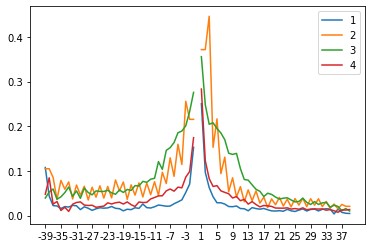

In [22]:
import matplotlib.pyplot as plt

for condition in range(4):
    test_crp= fast_mixed_crp(trials[list_types==condition+1], presentations[list_types==condition+1])
    test_crp[len(presentations[0])-1] = np.nan
    plt.plot(np.arange(len(test_crp)), test_crp, label=str(condition+1))
    plt.xticks(np.arange(0, len(test_crp), 4), np.arange(0, len(test_crp), 4) - 39)
    
plt.legend()